<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#로지스틱-회귀분석-과제" data-toc-modified-id="로지스틱-회귀분석-과제-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>로지스틱 회귀분석 과제</a></span></li></ul></div>

# 로지스틱 회귀분석 과제 

- 1) 타이타닉 데이터를 불러오고 survived를 종속변수(y)로, 나머지 변수들은 독립변수(X)로 설정하세요 


In [206]:
import pandas as pd 
import numpy as np
df = pd.read_csv("titanic.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


- 2) X의 결측치가 존재하는 행을 삭제하고, 범주형 변수를 더미변수화 시키세요 

In [189]:
df["age"] = df["age"].fillna(df["age"].mean())
df = df.drop("deck", axis = 1)
df = df.drop("embarked", axis = 1)
df = df.drop("who", axis = 1)
df = df.drop("adult_male",axis = 1)
df = df.drop("alive",axis = 1)
df = df.drop("alone",axis = 1)
df = df.drop("pclass", axis = 1)
df["embark_town"] = df["embark_town"].fillna("Southampton") 

In [190]:
object_col = df.dtypes[df.dtypes == "object"].index.values.tolist()

df = pd.get_dummies(data = df, columns = object_col, drop_first = True)

In [191]:
feature = df.drop("survived", axis = 1)
label = df["survived"]

- 3) 독립변수(X)를 StandardScaler를 통해 변환하세요 

In [192]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit_transform(feature)

In [193]:
feature = pd.DataFrame(data = scaler, columns = feature.columns)

- 4) X와 y를 홀드아웃 기법을 사용하여 7:3으로 분할하세요 

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = 0.3)

- 5) X_train과 y_train을 가지고 로지스틱 회귀분석모델을 만드세요

In [195]:
import statsmodels.api as sm

model = sm.Logit(y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.480365
         Iterations 7


In [196]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      614
Method:                           MLE   Df Model:                            8
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                  0.2817
Time:                        18:41:54   Log-Likelihood:                -299.27
converged:                       True   LL-Null:                       -416.64
Covariance Type:            nonrobust   LLR p-value:                 2.924e-46
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                        -0.4505      0.114     -3.956      0.000      -0.674      -0.227
sibsp                      -0.2723      0.123     -2.210      0.027      -0.514      -0.031
parch                      -0.1429      0.118     -1.208      0.227      -0.375       0.089
fare                        0.3064      0.192      1.598      0.110      -0.069       0.682
sex_male                   -1.2814      0.117    -10.951      0.000      -1.511      -1.052
class_Second               -0.2799      0.147     -1.905      0.057      -0.568       0.008
class_Third                -0.8319      0.177     -4.708      0.000      -1.178      -0.486
embark_town_Queenstown     -0.0478      0.125     -0.383      0.702      -0.292       0.197
embark_town_Southampton    -0.1670      0.124     -1.343      0.179      -0.411       0.077
===========================================================================================
"""

In [197]:
result.aic

616.5347216203181

- 6) 변수선택법을 통해 최적의 회귀 방정식을 구하고, 유의한 변수만을 추출하세요. (변수선택법은 복사 붙여넣기) 

In [198]:
import time
import itertools
def processSubset(X,y, feature_set):
            model = sm.Logit(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}
        
'''
전진선택법
'''
def forward(X, y, predictors):
    
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]))
        
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index

    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in")
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

'''
후진소거법
'''
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model



'''
단계적 선택법
'''

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = [X.columns[0]]
    Smodel_before = processSubset(X,y,predictors)['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors]
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors]
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [199]:
Stepwise_best_model = Stepwise_model(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.691274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.544686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680596
         Iterations 4
Processed  8 models on 2 predictors in
Selected predictors: ['age', 'sex_male']  A

Optimization terminated successfully.
         Current function value: 0.485251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.604432
         Iterations 6
Processed  7 models on 6 predictors in 0.0200042724609375
Selected predictors: ['sex_male', 'class_Third', 'age', 'class_Second', 'sibsp', 'fare']  AIC: <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000022E3D3F7520>
backward
Optimization terminated successfully.
         Current function value: 0.481920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481631
         Iterations 6
Processed  3 models on 7 predictors 

In [200]:
Stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      617
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Apr 2022   Pseudo R-squ.:                  0.2775
Time:                        18:41:54   Log-Likelihood:                -301.04
converged:                       True   LL-Null:                       -416.64
Covariance Type:            nonrobust   LLR p-value:                 5.917e-48
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sex_male        -1.2605      0.112    -11.238      0.000      -1.480      -1.041
class_Third     -0.8866      0.168     -5.268      0.000      -1.216      -0.557
age             -0.4541      0.114     -3.986      0.000      -0.677      -0.231
class_Second    -0.3361      0.142     -2.363      0.018      -0.615      -0.057
sibsp           -0.3312      0.119     -2.793      0.005      -0.564      -0.099
fare             0.2621      0.170      1.542      0.123      -0.071       0.595
================================================================================
"""

- 6) X_test값을 가지고 y_predict값을 구한 후 혼동행렬을 만드세요 

In [201]:
from sklearn.metrics import confusion_matrix
X_test = X_test[Stepwise_best_model.params.index]

pred = Stepwise_best_model.predict(X_test)
# print(pred)

def pred_1(df):
    df[df > 0.5] = 1
    df[df <= 0.5] =0
    
    return df


y_pred_1 = pred_1(pred)

print(confusion_matrix(y_test, y_pred_1))

[[129  40]
 [ 16  83]]


- 7) X_test값을 가지고 y_predict_proba 값을 구한 후 roc_auc_score를 구하고 해석하세요 

In [202]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred)

0.800848723925647

ROC AUC Score : 0.800848723925647


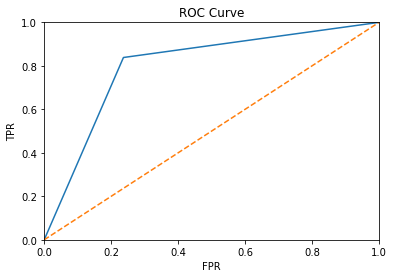

In [203]:
# roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, pred)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], ls = "--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
print("ROC AUC Score :", roc_auc_score(y_test, pred))

- 7) 회귀계수를 구하고, 유의한 회귀계수의 값을 설명하세요 

In [204]:
np.exp(Stepwise_best_model.params)

sex_male        0.283522
class_Third     0.412060
age             0.634993
class_Second    0.714541
sibsp           0.718031
fare            1.299707
dtype: float64